Ahh, statistical hypothesis testing—it's a cornerstone of classical statistical inference. 
It can also seem a bit daunting when presented as a list of [over 100 different methods](https://en.wikipedia.org/wiki/Category:Statistical_tests) 
from which the user is expected to choose the right procedure based on their application domain, data, and question.
But it doesn't have to be that way—there is a unifying perspective that can help us cut through that complexity.

*It turns out that many traditional frequentist tests can be viewed as special cases of regression models.*

This is a powerful and liberating idea, because it can help us transition from choosing from the zoo of canned methods to building our own bespoke analyses, tailored to our exact use case.
Adopting this perspective will allow us to

- transcend rote memorization of which test should be applied where and instead reason from first principles
- make our assumptions clear and explicit 
- make extensions like incorporating covariates and interactions more natural

So the plan for this post is to take a look at a few of the most common statistical tests, and formulate each one as a regression model. We'll implement each one using its dedicated stats library method and also a generic regression model.

Let's roll!

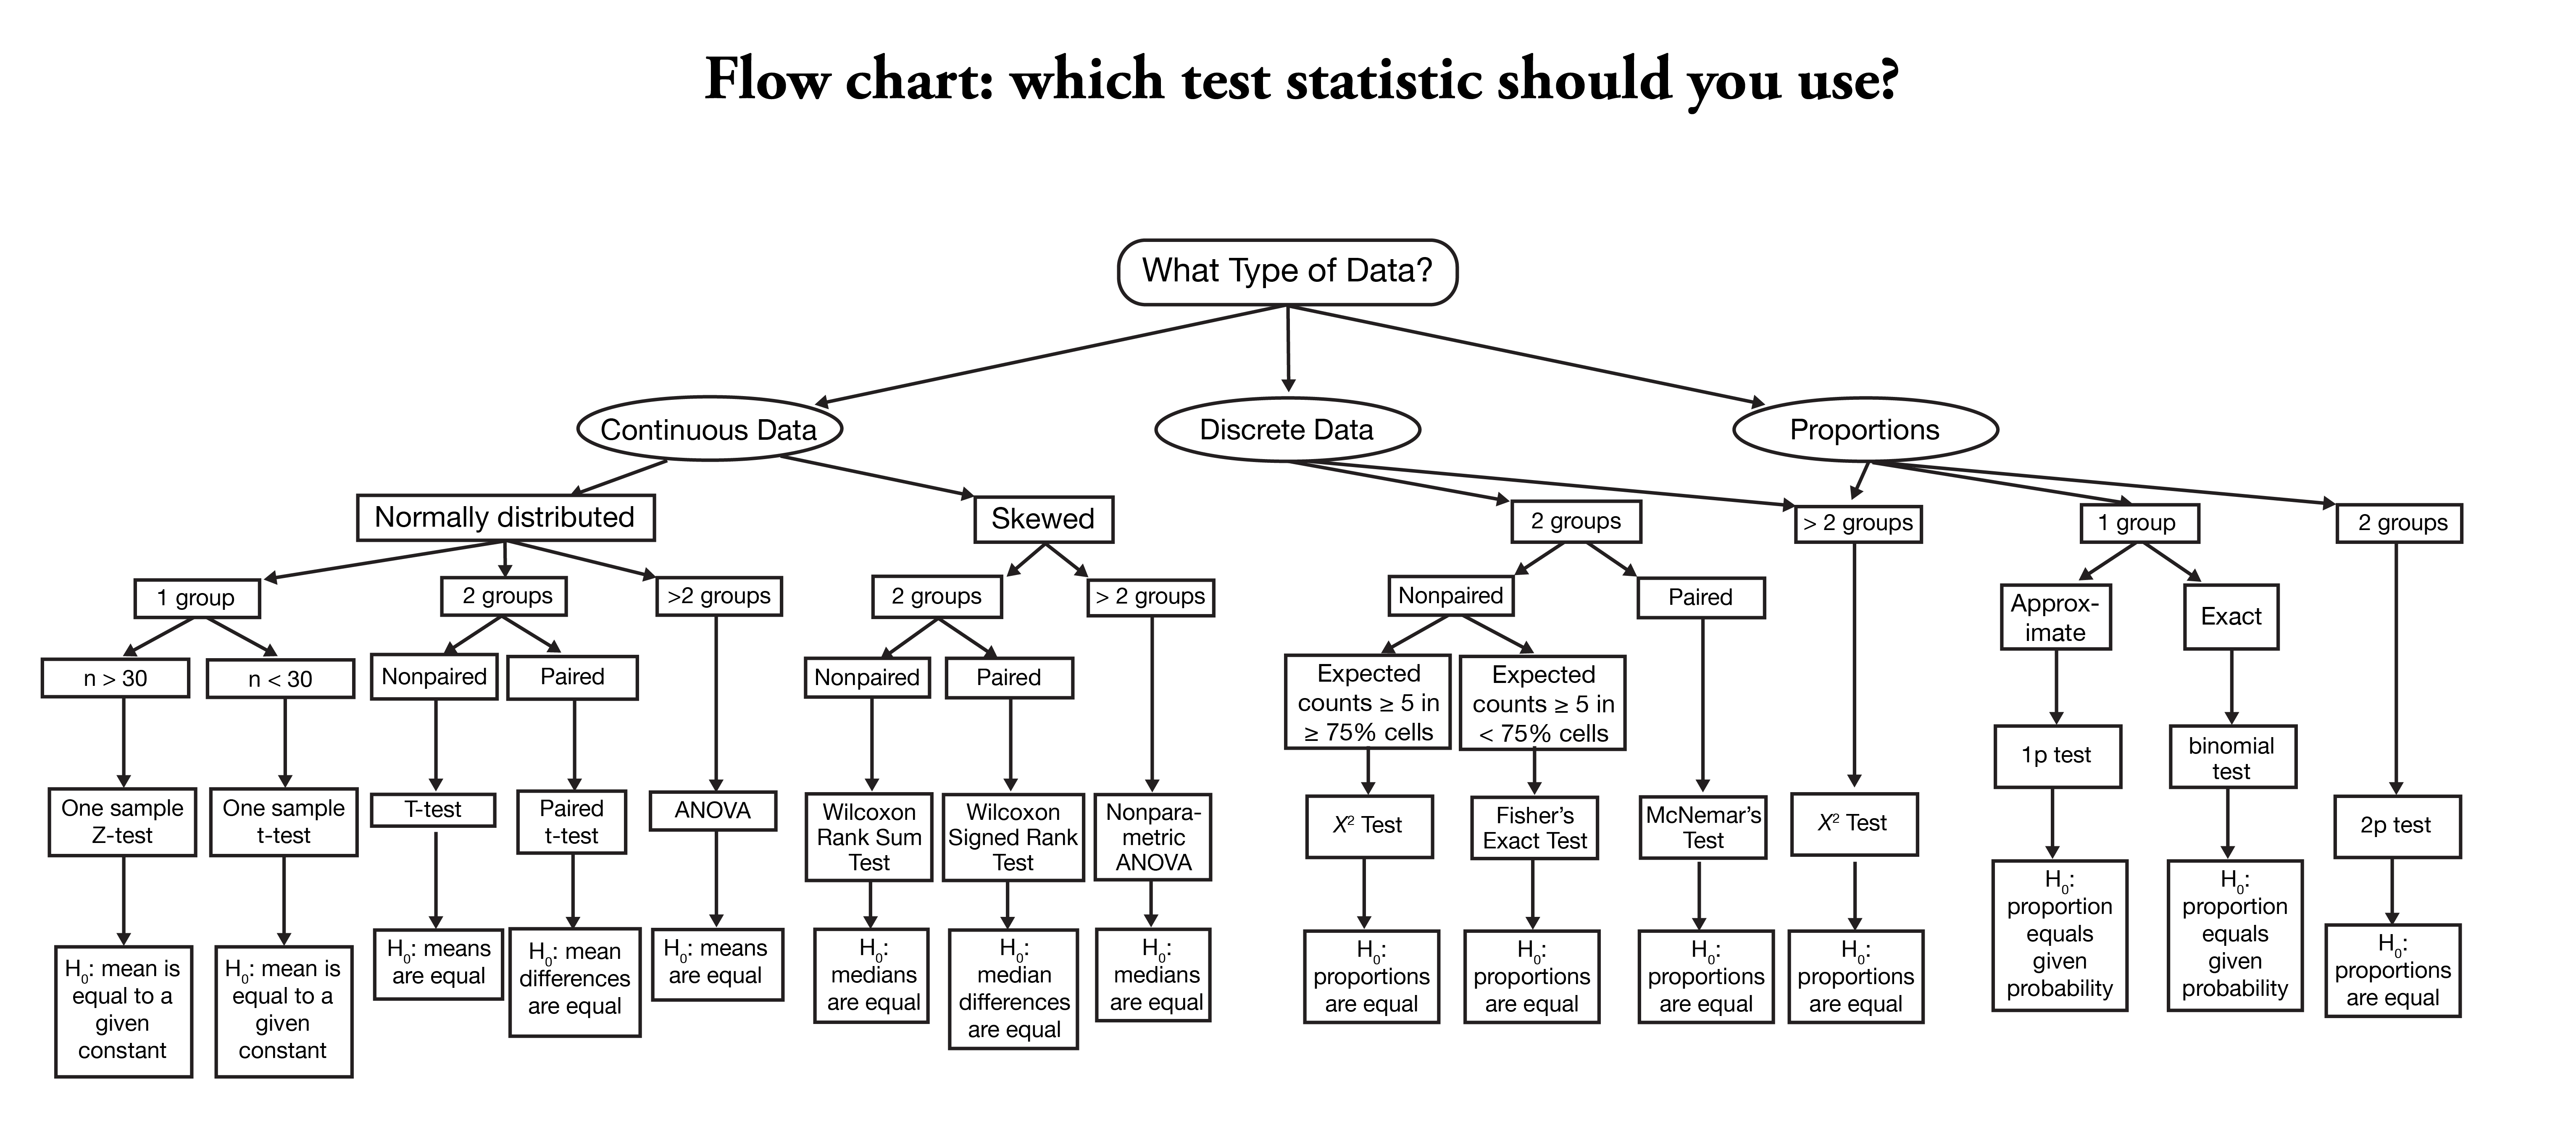

*Statistical test selection flowchart (good luck). [Source](https://onishlab.colostate.edu/wp-content/uploads/2019/07/)*

## Two-Sample t-test

So we're going to do a detailed analytical breakdown of the two-sample t-test from two perspectives—the classical setup and a linear regression reformulation. In each case we'll break the approach down into these items: data generating process, estimator, expectation and variance of the estimator, test statistic, and sampling distribution of the test statistic. You can use this kind of breakdown to understand pretty much any classical statistical test. In this case, the point is to clearly show that the classical t-test and the linear regression formulation yield identical tests. 

### The Classical t-test Approach

**The data generating process**

You have two populations or processes $Y_0$ and $Y_1$, and you want to know whether their true means $\mu_0$ and $\mu_1$ are equal. We assume that both processes are Gaussian with equal but unknown variance $\sigma^2$:

$$ Y_0 \sim N(\mu_0, \sigma^2), \quad Y_1 \sim N(\mu_1, \sigma^2) $$

**The estimator**

You draw $n_0$ samples from group 0 and $n_1$ samples from group 1 for a total of $n=n_0+n_1$ samples, and compute the sample means $\bar{Y}_0$ and $\bar{Y}_1$. Your estimator for the difference in means is simply:

$$\hat{\delta} = \bar{Y}_1 - \bar{Y}_0$$

**Expectation of the estimator**

Since $E[\bar{Y}_0] = \mu_0$ and $E[\bar{Y}_1] = \mu_1$, we have:

$$E[\hat{\delta}] = E[\bar{Y}_1 - \bar{Y}_0] = \mu_1 - \mu_0$$

So $\hat{\delta}$ is an unbiased estimator of the true difference in means.

**Standard error of the estimator**

The sample means are independent, so:

$$Var[\hat{\delta}] = Var[\bar{Y}_1] + Var[\bar{Y}_0] = \frac{\sigma^2}{n_1} + \frac{\sigma^2}{n_0} = \sigma^2\left(\frac{1}{n_1} + \frac{1}{n_0}\right)$$

Since we don't know $\sigma^2$, we estimate it with the pooled sample variance:

$$\hat{\sigma}_{\text{pooled}}^2 = \frac{(n_0-1)s_0^2 + (n_1-1)s_1^2}{n_0 + n_1 - 2}$$

where $s_0^2$ and $s_1^2$ are the sample variances for each group. This gives us the estimated standard error:

$$SE(\hat{\delta}) = \sqrt{\hat{\sigma}_{\text{pooled}}^2\left(\frac{1}{n_0} + \frac{1}{n_1}\right)}$$

**The test statistic**

We form the test statistic by dividing our estimator by its standard error:

$$t = \frac{\hat{\delta}}{SE(\hat{\delta})} = \frac{\bar{Y}_1 - \bar{Y}_0}{\sqrt{\hat{\sigma}_{\text{pooled}}^2 (1/n_0 + 1/n_1)}}$$

**Sampling distribution**

Under the null hypothesis $H_0: \mu_1 = \mu_0$, this test statistic follows a Student's t-distribution with $n_0 + n_1 - 2$ degrees of freedom.

Having horrifying flashbacks to your intro to stats class yet? No worries. Let's look at it from a new perspective.


### The Regression Approach

**The data generating process**

We can express the exact same data generating process as a linear regression model. Stack all observations into a single length-$n$ vector $Y$ and create a dummy variable $X \in \{0,1\}$ indexing which group each observation came from:

$$ Y = \beta_0 + \beta_1 X + \epsilon $$

where $\epsilon \overset{iid}{\sim} N(0, \sigma^2)$.

Taking conditional expectations:

$$ E[Y|X=0] = \beta_0 = \mu_0 $$
$$ E[Y|X=1] = \beta_0 + \beta_1 = \mu_1 $$

So we can see that $\beta_1 = \mu_1 - \mu_0$, meaning the regression coefficient $\beta_1$ directly represents the difference in population means.

**The estimator**

The ordinary least squares estimator for $\beta_1$ is:

$$\hat{\beta}_1 = \frac{\sum_{i=1}^{n} (X_i - \bar{X})(Y_i - \bar{Y})}{\sum_{i=1}^{n} (X_i - \bar{X})^2}$$

For our dummy variable where $\bar{X} = n_1/(n_0 + n_1)$, after some algebra that you can crank through on your own this simplifies to:

$$\hat{\beta}_1 = \bar{Y}_1 - \bar{Y}_0$$

Well look at that—the regression coefficient estimate is exactly the difference in sample means!

**Expectation of the estimator**

By the properties of OLS under our model assumptions:

$$E[\hat{\beta}_1] = \beta_1 = \mu_1 - \mu_0$$

So $\hat{\beta}_1$ is also an unbiased estimator of the difference in means.

**Standard error of the estimator**

The standard error formula for an OLS coefficient is:

$$SE(\hat{\beta}_1) = \sqrt{\hat{\sigma}^2 \cdot \frac{1}{\sum_{i=1}^{n}(X_i - \bar{X})^2}}$$

where $\hat{\sigma}^2$ is the residual variance from the regression:

$$\hat{\sigma}^2 = \frac{1}{n_0 + n_1 - 2}\sum_{i=1}^{n}(Y_i - \hat{Y}_i)^2$$

For our dummy variable, it turns out that:
- The residual variance $\hat{\sigma}^2$ equals the pooled variance $\hat{\sigma}_{\text{pooled}}^2$
- The sum $\sum_{i=1}^{n}(X_i - \bar{X})^2 = \frac{n_0 n_1}{n_0 + n_1}$

Substituting these:

$$SE(\hat{\beta}_1) = \sqrt{\hat{\sigma}_{\text{pooled}}^2 \cdot \frac{n_0 + n_1}{n_0 n_1}} = \sqrt{\hat{\sigma}_{\text{pooled}}^2\left(\frac{1}{n_0} + \frac{1}{n_1}\right)}$$

This is exactly the same standard error we got from the classical approach.

**The test statistic**

We form the test statistic by dividing our coefficient estimate by its standard error:

$$t = \frac{\hat{\beta}_1}{SE(\hat{\beta}_1)} = \frac{\bar{Y}_1 - \bar{Y}_0}{\sqrt{\hat{\sigma}_{\text{pooled}}^2 (1/n_0 + 1/n_1)}}$$

**Sampling distribution**

Under the null hypothesis $H_0: \beta_1 = 0$, this test statistic follows a Student's t-distribution with $n_0 + n_1 - 2$ degrees of freedom (the residual degrees of freedom from the regression).

### The Punchline

See what just happened? The two approaches give us:
- The same point estimate: $\hat{\delta} = \hat{\beta}_1 = \bar{Y}_1 - \bar{Y}_0$
- The same standard error: $\sqrt{\hat{\sigma}_{\text{pooled}}^2(1/n_0 + 1/n_1)}$
- The same test statistic: $t = \frac{\bar{Y}_1 - \bar{Y}_0}{\sqrt{\hat{\sigma}_{\text{pooled}}^2 (1/n_0 + 1/n_1)}}$
- The same sampling distribution: $t_{n_0+n_1-2}$
- Therefore, the same p-value

In other words these approaches are mathematically equivalent. 

### Implementation

Let's simulate some data and implement both testing approaches.

In [2]:
import numpy as np
from scipy import stats
import statsmodels.api as sm

# Simulate data
np.random.seed(42)
n0, n1 = 20, 25
mu0, mu1 = 10, 12
sigma = 2
group0 = np.random.normal(mu0, sigma, n0)
group1 = np.random.normal(mu1, sigma, n1)

# Traditional t-test
t_stat, p_val_ttest = stats.ttest_ind(group1, group0, equal_var=True)

# Regression approach
y = np.concatenate([group0, group1])
x = np.concatenate([np.zeros(n0), np.ones(n1)])
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()

# Compare
print(f"t-test statistic: {t_stat:.6f}")
print(f"Regression t-stat for β₁: {model.tvalues[1]:.6f}")

print(f"\nt-test p-value: {p_val_ttest:.6f}")
print(f"Regression p-value: {model.pvalues[1]:.6f}")

t-test statistic: 3.258749
Regression t-stat for β₁: 3.258749

t-test p-value: 0.002190
Regression p-value: 0.002190


As promised, the two-sample equal-variance t-test yields identical results to a linear regression with a dummy variable.

### Quick Rant on Clarity of Assumptions

I want to specifically highlight what I see as one of the greatest benefits of using a model-based approach for these testing problems. All of the key assumptions that we need to make are expressed compactly in the model that we write down to represent the data generating process. Here's the one we wrote down for comparing group means.

$$ Y = \beta_0 + \beta_1 X + \epsilon $$

where $\epsilon \overset{iid}{\sim} N(0, \sigma^2)$.

From this model spec, we can see the following assumptions are made
* The outcome is assumed to be normally distributed.
* The variance of the outcome is equal in the two groups.
* The samples in each group are  independent and identically distributed.

We don't have to memorize any lists of assumptions; we can simply read the model spec and see exactly what assumptions are being made about the data generating process.

## One-Way ANOVA

The two-sample t-test generalizes naturally to comparing means across more than two groups—that's one-way ANOVA. The classical ANOVA asks: "Are the means of $k$ groups all equal, or does at least one differ from the others?" 

From a regression perspective, this is just a linear model with a categorical predictor that has $k$ levels. We create $k-1$ dummy variables (leaving one group as the reference), and the F-test from ANOVA is equivalent to testing whether all the dummy variable coefficients are simultaneously zero.

Let's see this in action. We'll simulate data from three groups with different means and compare the classical ANOVA F-test to the F-test from a linear regression.


In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Simulate three groups with different means
np.random.seed(42)
n_per_group = 20
group_a = np.random.normal(10, 2, n_per_group)
group_b = np.random.normal(12, 2, n_per_group)
group_c = np.random.normal(11, 2, n_per_group)

# Create dataframe
df = pd.DataFrame({
    'value': np.concatenate([group_a, group_b, group_c]),
    'group': ['A']*n_per_group + ['B']*n_per_group + ['C']*n_per_group
})

# Classical one-way ANOVA
f_stat_anova, p_val_anova = stats.f_oneway(group_a, group_b, group_c)

# Regression approach
model = ols('value ~ C(group)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("Classical ANOVA:")
print(f"  F-statistic: {f_stat_anova:.6f}")
print(f"  p-value: {p_val_anova:.6f}")

print("\nRegression ANOVA:")
print(f"  F-statistic: {anova_table.loc['C(group)', 'F']:.6f}")
print(f"  p-value: {anova_table.loc['C(group)', 'PR(>F)']:.6f}")

Classical ANOVA:
  F-statistic: 5.145429
  p-value: 0.008824

Regression ANOVA:
  F-statistic: 5.145429
  p-value: 0.008824


Nice! The F-statistics and p-values match perfectly. The ANOVA is testing whether the group coefficients in the regression are all zero—which is exactly what the classical ANOVA F-test does.

## Chi-Squared Test of Independence

The chi-squared test asks whether two categorical variables are independent. The classic example: is group (A vs. B) independent of outcome (success vs. failure)? If you arrange the counts in a 2×2 contingency table, the chi-squared test tells you whether the proportions differ significantly between groups.

From a regression perspective, this is testing whether a binary outcome's probability depends on a categorical predictor—which is exactly what logistic regression does. For a 2×2 table, we model the log-odds of the outcome as a function of group membership, and testing independence is equivalent to testing whether the logistic regression coefficient equals zero.

> Note: unlike linear regression where we can use t-tests on coefficients to determine if a predictor matters, logistic regression and other GLMs typically use likelihood ratio tests to compare the full model with one that has the predictor of interest dropped. 

Let's simulate some binary outcome data for two groups and compare the classical chi-squared test to a logistic regression.

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import logit

# Simulate binary outcomes for two groups
np.random.seed(42)
n_a = 100
n_b = 100

# Group A: 30% success rate
group_a_outcomes = np.random.binomial(1, 0.30, n_a)

# Group B: 50% success rate
group_b_outcomes = np.random.binomial(1, 0.50, n_b)

# Create contingency table
contingency_table = pd.crosstab(
    index=pd.Series(['A']*n_a + ['B']*n_b, name='group'),
    columns=pd.Series(np.concatenate([group_a_outcomes, group_b_outcomes]), name='outcome')
)

# Classical chi-squared test
chi2_stat, p_val_chi2, dof, expected = stats.chi2_contingency(contingency_table)

# Logistic regression approach
df = pd.DataFrame({
    'outcome': np.concatenate([group_a_outcomes, group_b_outcomes]),
    'group': ['A']*n_a + ['B']*n_b
})

logit_model = logit('outcome ~ C(group)', data=df).fit(disp=0)

# Get the likelihood ratio test statistic (comparable to chi-squared)
lr_stat = logit_model.llr  # Likelihood ratio test statistic
p_val_lr = logit_model.llr_pvalue

print("Classical Chi-Squared Test:")
print(f"  χ² statistic: {chi2_stat:.6f}")
print(f"  p-value: {p_val_chi2:.6f}")

print("\nLogistic Regression (Likelihood Ratio Test):")
print(f"  LR χ² statistic: {lr_stat:.6f}")
print(f"  p-value: {p_val_lr:.6f}")

Classical Chi-Squared Test:
  χ² statistic: 8.299616
  p-value: 0.003965

Logistic Regression (Likelihood Ratio Test):
  LR χ² statistic: 9.232498
  p-value: 0.002378


 Whoa, this time we get slightly different test statistics and p-values; what's happening here? 
   
The classical Pearson chi-squared test and the likelihood ratio test from logistic regression are 
actually *different test statistics* testing the same hypothesis. Both are asymptotically 
chi-squared distributed under the null, but they use different formulas and give different 
values for finite samples. The p-values are close and lead to the same conclusion—both are 
testing whether group membership and outcome are independent.

There are many valid ways to answer questions using data, and appropriate approaches will tend to agree with each other.

## Wrapping Up

We've just scratched the surface of this simple idea that we can take a model-based approach to inference in many cases where the default might be to use a traditional canned statistical procedure. 
Doing so has many benefits, including making assumptions clear, extensibility to more complex scenarios with other covariates and interactions, and naturally enabling us to use Bayesian inference to do inference on the model parameters. 
Next time you reach for a statistical test, ask yourself: what model would generate this data? You might find yourself in a more creative and insightful analysis process than that canned test could ever hope to provide.